<font color="#CC3D3D"><p>
# 트랜잭션 데이터로부터 feature를 생성한 후 학습용과 평가용 데이터로 나누기

- **Input**: 트랜잭션 데이터(`train_transactions.csv`, `test_transactions.csv`)
- **Output**: 위 데이터로부터 파생변수(feature)를 만든 후 모형 학습용(`X_train.csv`)과 평가용(`X_test.csv`) 데이터 생성

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
from scipy import stats
%matplotlib inline

pd.set_option('max_columns', 20, 'max_rows', 20)

In [44]:
# 차트에서 한글 출력을 위한 설정
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

<font color="blue"><p>
## Read Transactions

In [45]:
train = pd.read_csv('train_transactions.csv', encoding='cp949')
test = pd.read_csv('test_transactions.csv', encoding='cp949')
tr = pd.concat([train, test])

In [46]:
train

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000
...,...,...,...,...,...,...,...
231999,3499,2007-12-17 00:00:00,본 점,127129,상품군미지정,기타,-135000
232000,3499,2007-12-23 00:00:00,노원점,285136,시티웨어,시티웨어,6380000
232001,3499,2007-12-23 00:00:00,노원점,39107,야채,농산물,40800
232002,3499,2007-12-27 00:00:00,본 점,740120,어덜트,명품,4880000


## Feature Generation

*새로 만든 feature와 병합할 고객ID로만 이루어진 데이터프레임을 만든다.*

In [47]:
features = pd.DataFrame({'cust_id': tr.cust_id.unique()})

<br><font color='green'>
### Numeric Features

- 팀원들의 기본 코드 3개 중에서 토의한 결과 후안의 코드를 기본 코드로 진행하게 되었다. 그 위에 feature를 합쳐서 총 14개의 feature를 만들게 됨. 

**[파생변수 1-4]** 총구매액, 구매건수, 평균구매액, 최대구매액

In [48]:
# 손질평균구매액 : 이상치 없는 평균구매액

f = tr.groupby('cust_id')['amount'].agg([
    ('총구매액',np.sum), 
    ('구매건수', lambda x: np.size(x)), 
    ('손질평균구매액', lambda x: np.round(stats.trim_mean(x, 0.1))), 
    (('최저구매액', np.min)),
    (('최대구매액', np.max)),
]).reset_index()

features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,손질평균구매액,최저구매액,최대구매액
0,0,68282840,74,606119,-5368000,11264000
1,1,2136000,3,712000,-300000,2136000
2,2,3197000,4,799250,64500,1639000
3,3,16077620,44,121837,1800,4935000
4,4,29050000,3,9683333,2050000,24000000
...,...,...,...,...,...,...
5977,5977,82581500,14,4850042,405000,23976000
5978,5978,480000,1,480000,480000,480000
5979,5979,260003790,71,2506764,1250,25750000
5980,5980,88991520,18,4401970,440000,18120000


In [49]:
tr['tran_date'] = pd.to_datetime(tr.tran_date, format="%Y-%m-%d %H:%M:%S")
tr['tr_month'] = tr['tran_date'].dt.month
features['월'] = tr.groupby('cust_id')['tr_month'].max()

In [50]:
# feature : 일
tr['tran_date'] = pd.to_datetime(tr.tran_date, format="%Y-%m-%d %H:%M:%S")
tr['tr_day'] = tr['tran_date'].dt.day
features['일'] = tr.groupby('cust_id')['tr_day'].max()

In [51]:
f = tr.groupby('cust_id')['gds_grp_mclas_nm'].agg([
    (('최대제품', np.max))
]).reset_index()
features = features.merge(f, how='left', left_index=False); features

,cust_id,총구매액,구매건수,손질평균구매액,최저구매액,최대구매액,월,일,최대제품
0,0,68282840,74,606119,-5368000,11264000,12,30,화장품
1,1,2136000,3,712000,-300000,2136000,10,25,트래디셔널
2,2,3197000,4,799250,64500,1639000,1,10,남성 캐주얼
3,3,16077620,44,121837,1800,4935000,12,31,캐주얼
4,4,29050000,3,9683333,2050000,24000000,11,28,화장품
...,...,...,...,...,...,...,...,...,...
5977,5977,82581500,14,4850042,405000,23976000,12,14,피혁잡화
5978,5978,480000,1,480000,480000,480000,1,22,섬유잡화
5979,5979,260003790,71,2506764,1250,25750000,12,30,피혁잡화
5980,5980,88991520,18,4401970,440000,18120000,12,14,침구/수예


**[make features]** 
- 휴면_여부
- Top-10 베스트 셀러에 대한 구매 금액
- Top-10 베스트 셀러에 대한 구매 건수
- 평일방문비율

In [52]:
# 휴면 여부
f = tr.groupby('cust_id')['tran_date'].agg([
    ('휴면_여부', lambda x: int((tr.tran_date.astype('datetime64').max() - x.astype('datetime64').max()).days))
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,손질평균구매액,최저구매액,최대구매액,월,일,최대제품,휴면_여부
0,0,68282840,74,606119,-5368000,11264000,12,30,화장품,7
1,1,2136000,3,712000,-300000,2136000,10,25,트래디셔널,67
2,2,3197000,4,799250,64500,1639000,1,10,남성 캐주얼,355
3,3,16077620,44,121837,1800,4935000,12,31,캐주얼,17
4,4,29050000,3,9683333,2050000,24000000,11,28,화장품,47
...,...,...,...,...,...,...,...,...,...,...
5977,5977,82581500,14,4850042,405000,23976000,12,14,피혁잡화,30
5978,5978,480000,1,480000,480000,480000,1,22,섬유잡화,343
5979,5979,260003790,71,2506764,1250,25750000,12,30,피혁잡화,1
5980,5980,88991520,18,4401970,440000,18120000,12,14,침구/수예,23


In [53]:
f = tr.groupby('cust_id')['tran_date'].agg([
       ('평일방문비율', lambda x: np.mean(pd.to_datetime(x).dt.dayofweek>4))
    ]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,손질평균구매액,최저구매액,최대구매액,월,일,최대제품,휴면_여부,평일방문비율
0,0,68282840,74,606119,-5368000,11264000,12,30,화장품,7,0.527027
1,1,2136000,3,712000,-300000,2136000,10,25,트래디셔널,67,0.000000
2,2,3197000,4,799250,64500,1639000,1,10,남성 캐주얼,355,0.000000
3,3,16077620,44,121837,1800,4935000,12,31,캐주얼,17,0.318182
4,4,29050000,3,9683333,2050000,24000000,11,28,화장품,47,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,82581500,14,4850042,405000,23976000,12,14,피혁잡화,30,0.642857
5978,5978,480000,1,480000,480000,480000,1,22,섬유잡화,343,0.000000
5979,5979,260003790,71,2506764,1250,25750000,12,30,피혁잡화,1,0.915493
5980,5980,88991520,18,4401970,440000,18120000,12,14,침구/수예,23,0.444444


In [54]:
x = []
for i in range(10):
    a= tr.gds_grp_mclas_nm.value_counts().head(10).index[i]
    x.append(a)
x

['기타', '농산물', '가공식품', '축산가공', '수산품', '화장품', '디자이너', '시티웨어', '일용잡화', '육류']

In [55]:
f = tr.query("gds_grp_mclas_nm in {}".format(x)).groupby('cust_id')['amount'].agg([
    ('Top-10 베스트 셀러에 대한 구매 금액', np.sum),
    ('Top-10 베스트 셀러에 대한 구매 건수', np.size)
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,손질평균구매액,최저구매액,최대구매액,월,일,최대제품,휴면_여부,평일방문비율,Top-10 베스트 셀러에 대한 구매 금액,Top-10 베스트 셀러에 대한 구매 건수
0,0,68282840,74,606119,-5368000,11264000,12,30,화장품,7,0.527027,45689940.0,51.0
1,1,2136000,3,712000,-300000,2136000,10,25,트래디셔널,67,0.000000,NaN,NaN
2,2,3197000,4,799250,64500,1639000,1,10,남성 캐주얼,355,0.000000,139000.0,2.0
3,3,16077620,44,121837,1800,4935000,12,31,캐주얼,17,0.318182,4411020.0,36.0
4,4,29050000,3,9683333,2050000,24000000,11,28,화장품,47,0.000000,5050000.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,82581500,14,4850042,405000,23976000,12,14,피혁잡화,30,0.642857,25948000.0,4.0
5978,5978,480000,1,480000,480000,480000,1,22,섬유잡화,343,0.000000,NaN,NaN
5979,5979,260003790,71,2506764,1250,25750000,12,30,피혁잡화,1,0.915493,4188350.0,10.0
5980,5980,88991520,18,4401970,440000,18120000,12,14,침구/수예,23,0.444444,51869020.0,12.0


In [63]:
features.dtypes

cust_id                      int64
총구매액                         int64
구매건수                         int64
손질평균구매액                      int64
최저구매액                        int64
최대구매액                        int64
월                            int64
일                            int64
최대제품                        object
휴면_여부                        int64
평일방문비율                     float64
Top-10 베스트 셀러에 대한 구매 금액    float64
Top-10 베스트 셀러에 대한 구매 건수    float64
dtype: object

feature selection에 대해서는 직관적으로 모든 feature를 보면서 간추렸다.

# Shap Value(SHapley Additive exPlanations)

- Shap Value : 하나의 특성에 대한 중요도를 알기위해 여러 특성들의 조합을 구성하고 해당 특성의 유무에 따른 평균적인 변화를 통해 얻어낸 값
- 특징 : 범주형 데이터는 Shap Value를 측정할 수 없고, 수치형 데이터만을 이용해서 Shap Value를 측정해 feature들 중에서 의미 있는 feature를 찾을 수 있다.

<br><font color='green'>
### Feature Correlation

/home/ubuntu/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 52509 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50529 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarni

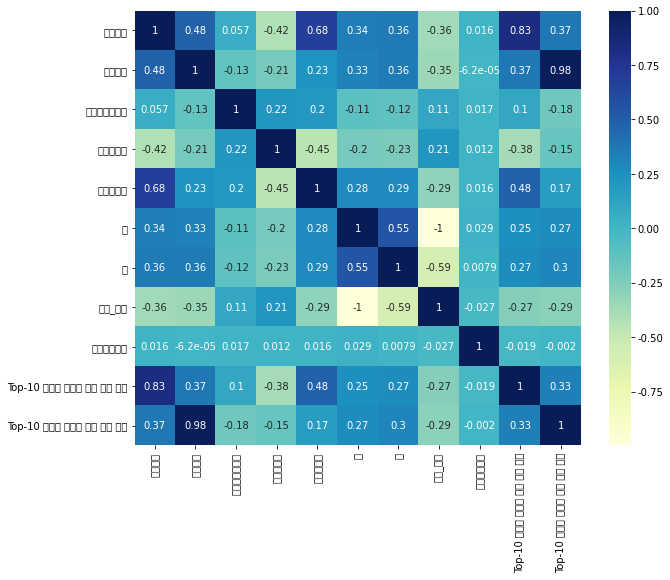

In [56]:
# 상관계수(-1 ~ +1)를 통해 feature 간의 유사성을 파악 
plt.figure(figsize=(10,8))
sns.heatmap(features.iloc[:,1:].corr(), annot=True, cmap="YlGnBu")
plt.show()

<font color="blue"><p>
## Save Features
- 아래 코드를 수행하면 생성한 모든 파생변수가 학습용과 평가용으로 분리되어 저장된다.

In [57]:
display(features)
features.info()

,cust_id,총구매액,구매건수,손질평균구매액,최저구매액,최대구매액,월,일,최대제품,휴면_여부,평일방문비율,Top-10 베스트 셀러에 대한 구매 금액,Top-10 베스트 셀러에 대한 구매 건수
0,0,68282840,74,606119,-5368000,11264000,12,30,화장품,7,0.527027,45689940.0,51.0
1,1,2136000,3,712000,-300000,2136000,10,25,트래디셔널,67,0.000000,NaN,NaN
2,2,3197000,4,799250,64500,1639000,1,10,남성 캐주얼,355,0.000000,139000.0,2.0
3,3,16077620,44,121837,1800,4935000,12,31,캐주얼,17,0.318182,4411020.0,36.0
4,4,29050000,3,9683333,2050000,24000000,11,28,화장품,47,0.000000,5050000.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,82581500,14,4850042,405000,23976000,12,14,피혁잡화,30,0.642857,25948000.0,4.0
5978,5978,480000,1,480000,480000,480000,1,22,섬유잡화,343,0.000000,NaN,NaN
5979,5979,260003790,71,2506764,1250,25750000,12,30,피혁잡화,1,0.915493,4188350.0,10.0
5980,5980,88991520,18,4401970,440000,18120000,12,14,침구/수예,23,0.444444,51869020.0,12.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5982 entries, 0 to 5981
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cust_id                  5982 non-null   int64  
 1   총구매액                     5982 non-null   int64  
 2   구매건수                     5982 non-null   int64  
 3   손질평균구매액                  5982 non-null   int64  
 4   최저구매액                    5982 non-null   int64  
 5   최대구매액                    5982 non-null   int64  
 6   월                        5982 non-null   int64  
 7   일                        5982 non-null   int64  
 8   최대제품                     5982 non-null   object 
 9   휴면_여부                    5982 non-null   int64  
 10  평일방문비율                   5982 non-null   float64
 11  Top-10 베스트 셀러에 대한 구매 금액  5402 non-null   float64
 12  Top-10 베스트 셀러에 대한 구매 건수  5402 non-null   float64
dtypes: float64(3), int64(9), object(1)
memory usage: 654.3+ KB


In [60]:
X_train = pd.DataFrame({'cust_id': np.sort(train['cust_id'].unique())}).merge(features)
X_train.to_csv('X_train.csv', index=False, encoding='cp949')

X_test = pd.DataFrame({'cust_id': np.sort(test['cust_id'].unique())}).merge(features)
X_test.to_csv('X_test.csv', index=False, encoding='cp949')

In [62]:
X_test

,cust_id,총구매액,구매건수,손질평균구매액,최저구매액,최대구매액,월,일,최대제품,휴면_여부,평일방문비율,Top-10 베스트 셀러에 대한 구매 금액,Top-10 베스트 셀러에 대한 구매 건수
0,3500,70900400,19,3114729,-4050000,22000000,12,31,화장품,9,0.789474,2950100.0,5.0
1,3501,310533100,219,604194,-13884000,38558000,12,31,트래디셔널,0,0.369863,12960700.0,110.0
2,3502,305264140,1477,92326,-14825000,14825000,12,31,화장품,0,0.083277,187394510.0,1311.0
3,3503,7594080,10,295322,6500,5225000,8,30,화장품,125,0.000000,5533900.0,3.0
4,3504,1795790,8,224474,1250,1411200,2,24,축산가공,325,0.125000,384590.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,5977,82581500,14,4850042,405000,23976000,12,14,피혁잡화,30,0.642857,25948000.0,4.0
2478,5978,480000,1,480000,480000,480000,1,22,섬유잡화,343,0.000000,NaN,NaN
2479,5979,260003790,71,2506764,1250,25750000,12,30,피혁잡화,1,0.915493,4188350.0,10.0
2480,5980,88991520,18,4401970,440000,18120000,12,14,침구/수예,23,0.444444,51869020.0,12.0


<font color="#CC3D3D"><p>
# End